In [1]:
# Import stuff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import utils

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Fetch the MNIST dataset
mnist_dir = "data/MNIST_sklearn"
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home=mnist_dir)

# Scale feature values between 0 and 1
X = X / 255.0
X = X.astype(np.float32)

# Convert targets to integers
y = y.astype(int)

# Shuffle the dataset
shuffled_indices = np.random.permutation(len(X))
X = X[shuffled_indices]
y = y[shuffled_indices]

# Split into training and test set
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

# Convert to tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


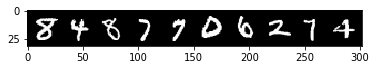

tensor([8, 4, 8, 7, 7, 0, 6, 2, 7, 4])


In [3]:
# Function to show an image
def imshow(image):
    image_np = image.numpy()
    image_2d = image_np.reshape(28, 28)
    plt.imshow(image_2d, cmap='gray')
    plt.show()
    
# Function to show images in a grid
def imshow_grid(images, images_per_row=10):
    images_2d = images.view(-1, 1, 28, 28)
    images_grid = utils.make_grid(images_2d, nrow=images_per_row).permute(1, 2, 0)
    image_np = images_grid.numpy()
    plt.imshow(image_np, cmap='gray')
    plt.show()
        
imshow_grid(X_train[:10])
print(y_train[:10])

In [4]:
# Create a class for the neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# A function to fetch batches of data
def fetch_batch(X, y, batch_size=256):
    shuffled_indices = np.random.permutation(len(X))
    for i in range(0, len(X), batch_size):
        X_batch = X[shuffled_indices[i:i+batch_size]]
        y_batch = y[shuffled_indices[i:i+batch_size]]
        yield X_batch, y_batch

# A function to train the model for one epoch
def train(model, optimizer, show_loss=False):
    model.train()  # set the model to training mode
    for data, target in fetch_batch(X_train, y_train, 256):
        data, target = data.to(device), target.to(device)  # send data to the specified device
        optimizer.zero_grad()  # reset gradients
        output = model(data)  # perform forward propagation
        loss = F.cross_entropy(output, target)  # compute loss
        loss.backward()  # perform backward propagation
        optimizer.step()  # take an optimization step
        if show_loss:
            print("Loss:", loss.item() / len(data))
            
# A function to evaluate the model
def test(model):
    model.eval()  # set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in fetch_batch(X_test, y_test, 256):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).sum().item()
            predictions = output.argmax(dim=1)
            correct += (predictions == target).sum().item()
            
    print("Average loss: {:.4f},  Accuracy = {:.1f}%\n".format(test_loss/len(X_test), 100.0*correct/len(X_test)))

In [6]:
# Create the model
model = Net().to(device)

# Create the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Train and test the model
n_epochs = 10
for epoch in range(n_epochs):
    print("Epoch:", epoch)
    train(model, optimizer)
    test(model)

Epoch: 0
Average loss: 0.0011,  Accuracy = 92.2%

Epoch: 1
Average loss: 0.0008,  Accuracy = 94.2%

Epoch: 2
Average loss: 0.0006,  Accuracy = 95.4%

Epoch: 3
Average loss: 0.0006,  Accuracy = 96.0%

Epoch: 4
Average loss: 0.0005,  Accuracy = 96.3%

Epoch: 5
Average loss: 0.0004,  Accuracy = 96.8%

Epoch: 6
Average loss: 0.0004,  Accuracy = 96.9%

Epoch: 7
Average loss: 0.0004,  Accuracy = 96.9%

Epoch: 8
Average loss: 0.0004,  Accuracy = 97.1%

Epoch: 9
Average loss: 0.0004,  Accuracy = 97.2%



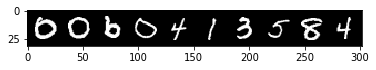

Predictions: [0, 0, 6, 0, 4, 1, 3, 5, 8, 4]


In [8]:
# Show some images
images = X_test[:10]
imshow_grid(images)

# Use the model to predict the labels
images = images.to(device)
output = model(images)
predictions = output.argmax(dim=1)
print("Predictions:", predictions.tolist())